In [138]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD
from keras import regularizers

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [139]:
# Loading the dataset
dataset = pd.read_csv('pulsar_stars.csv')

1. Once the dataset is loaded, let's see some relevant information about the dataset such as column's titles and types, number of records and shape.

In [140]:
# EDA
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 Mean of the integrated profile                  17898 non-null float64
 Standard deviation of the integrated profile    17898 non-null float64
 Excess kurtosis of the integrated profile       17898 non-null float64
 Skewness of the integrated profile              17898 non-null float64
 Mean of the DM-SNR curve                        17898 non-null float64
 Standard deviation of the DM-SNR curve          17898 non-null float64
 Excess kurtosis of the DM-SNR curve             17898 non-null float64
 Skewness of the DM-SNR curve                    17898 non-null float64
target_class                                     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB
None


In [141]:
# Missing values
print (dataset.isnull().sum())

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64


In [142]:
# Plotting the correlation between variables
#correlation = dataset.corr()

#plt.figure(figsize=(10,8))

#sns.heatmap(correlation,annot=True,
            #cmap=sns.color_palette("magma"),
            #linewidth=2,edgecolor="k")

#plt.title("CORRELATION BETWEEN VARIABLES")
#plt.savefig('correlation_between_variabels.png', bbox_inches='tight')

Now, Pay close attention to this plot. Note that the proportion between classes in the dataset is very imbalanced, this is a common problem encountered among many datasets in the real-world. This leads to the accuracy paradox, which implies that we'll need to use more than the usual approach to achieve a reasonable performance while training the neural network.

In [143]:
#plt.figure(figsize=(12,6))
#plt.subplot(121)
#ax = sns.countplot(y = dataset["target_class"],
                   #palette=["g","b"],
                   #linewidth=1,
                   #edgecolor="k"*2)
#for i,j in enumerate(dataset["target_class"].value_counts().values):
    #ax.text(.7,i,j,weight = "bold",fontsize = 27)
#plt.title("Count for target variable in datset")


#plt.subplot(122)
#plt.pie(dataset["target_class"].value_counts().values,
        #labels=["not pulsar stars","pulsar stars"],
        #autopct="%1.0f%%",wedgeprops={"linewidth":2,"edgecolor":"white"})
#my_circ = plt.Circle((0,0),.7,color = "white")
#plt.gca().add_artist(my_circ)
#plt.subplots_adjust(wspace = .2)
#plt.title("Proportion of target variable in dataset")
#plt.savefig('proportion_between_classes.jpg')

2. Now, let's divide our dataset into two subsets: data and target.

In [144]:
from sklearn.preprocessing import StandardScaler
# Droping the target column
data = dataset.drop(['target_class'], axis=1)

# Normalizing the data for all data points to fit in the range [0,1]
scaler = StandardScaler()
data = scaler.fit_transform(data)

target = dataset[['target_class']]

In [145]:
# UNDERSAMPLING Saved for later improvement
#from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(ratio = {0 : 8000, 1 : 1639}, return_indices=True)
#X_rus, y_rus, id_rus = rus.fit_sample(data, target)

In [146]:
# Construct the training and testing splits 
trainX, testX, trainY, testY = train_test_split(data, target, test_size=0.25)

Machine Learning algorithms works better when integer labels are transformed into vector labels. In order to accomplish this transformation I will instantiate a LabelBinarizer object and apply the transformation methods into our trainY and testY sets.

In [147]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

With keras, it is possible to define models to our neural network (nn). In this case, we are going to work with a Sequential nn, which is just the nn as we already know, i.e., each layer has as its input the output of the former layer. It is worth mention that our neural network is 8-4-2-1.

In [148]:
# Defining the model
model = Sequential()
model.add(Dense(4, input_shape=(8,), activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

We are going to use the Stochastic Gradient Descent technique as an optimizer, initially with a learning rate = 0.12 and a momentum = 0.7. Furthermore, as this is a binary classification problem, in this case a common loss function to use is the binary cross-entropy. However, as we have imbalanced classes, we need to tell the network that during the training, the positive class is more important than the negative. This has been done through the class weight dictionary, in this case, I am telling the network that during the training data positive points are 7 times more important than the negative ones.

In [149]:
sgd = SGD(0.12, momentum=0.4)

model.compile(loss='binary_crossentropy', optimizer=sgd,
    metrics=["accuracy"])

class_weight = {0 : 1., 1 : 2.}

H = model.fit(trainX, trainY, validation_data=(testX, testY), 
              batch_size=128, epochs=150, class_weight=class_weight, verbose=2)

scores = model.evaluate(testX, testY, verbose = 0)

Train on 13423 samples, validate on 4475 samples
Epoch 1/150
 - 2s - loss: 0.4281 - acc: 0.9103 - val_loss: 0.2601 - val_acc: 0.9028
Epoch 2/150
 - 0s - loss: 0.3357 - acc: 0.9103 - val_loss: 0.2050 - val_acc: 0.9028
Epoch 3/150
 - 0s - loss: 0.2672 - acc: 0.9251 - val_loss: 0.1742 - val_acc: 0.9540
Epoch 4/150
 - 0s - loss: 0.2235 - acc: 0.9607 - val_loss: 0.1466 - val_acc: 0.9634
Epoch 5/150
 - 0s - loss: 0.1893 - acc: 0.9724 - val_loss: 0.1225 - val_acc: 0.9716
Epoch 6/150
 - 0s - loss: 0.1647 - acc: 0.9772 - val_loss: 0.1101 - val_acc: 0.9736
Epoch 7/150
 - 0s - loss: 0.1501 - acc: 0.9778 - val_loss: 0.1010 - val_acc: 0.9759
Epoch 8/150
 - 0s - loss: 0.1410 - acc: 0.9777 - val_loss: 0.0974 - val_acc: 0.9759
Epoch 9/150
 - 0s - loss: 0.1350 - acc: 0.9778 - val_loss: 0.0926 - val_acc: 0.9777
Epoch 10/150
 - 0s - loss: 0.1309 - acc: 0.9781 - val_loss: 0.0915 - val_acc: 0.9768
Epoch 11/150
 - 0s - loss: 0.1279 - acc: 0.9782 - val_loss: 0.0892 - val_acc: 0.9772
Epoch 12/150
 - 0s - loss

Epoch 97/150
 - 0s - loss: 0.1045 - acc: 0.9796 - val_loss: 0.0775 - val_acc: 0.9799
Epoch 98/150
 - 0s - loss: 0.1047 - acc: 0.9794 - val_loss: 0.0753 - val_acc: 0.9794
Epoch 99/150
 - 0s - loss: 0.1045 - acc: 0.9799 - val_loss: 0.0768 - val_acc: 0.9797
Epoch 100/150
 - 0s - loss: 0.1046 - acc: 0.9792 - val_loss: 0.0773 - val_acc: 0.9799
Epoch 101/150
 - 0s - loss: 0.1045 - acc: 0.9794 - val_loss: 0.0766 - val_acc: 0.9799
Epoch 102/150
 - 0s - loss: 0.1044 - acc: 0.9788 - val_loss: 0.0753 - val_acc: 0.9797
Epoch 103/150
 - 0s - loss: 0.1044 - acc: 0.9794 - val_loss: 0.0757 - val_acc: 0.9803
Epoch 104/150
 - 0s - loss: 0.1038 - acc: 0.9801 - val_loss: 0.0782 - val_acc: 0.9792
Epoch 105/150
 - 0s - loss: 0.1041 - acc: 0.9789 - val_loss: 0.0756 - val_acc: 0.9797
Epoch 106/150
 - 0s - loss: 0.1041 - acc: 0.9791 - val_loss: 0.0777 - val_acc: 0.9797
Epoch 107/150
 - 0s - loss: 0.1039 - acc: 0.9794 - val_loss: 0.0744 - val_acc: 0.9790
Epoch 108/150
 - 0s - loss: 0.1040 - acc: 0.9793 - val_lo

At this point we are ready to analyze the results from our neural network. Calling the .predict method on our model will give us the predictions from our testing set. In addition, as the output from our network is given by the sigmoid activation function, the outputs values are real number in the range [0,1], so, we need to apply a step function to threshold the outputs to binary class labels. Lastly, we print a report showing us the performance of the model.

In [150]:
predictions = model.predict(testX, batch_size=128)

# apply a step function to threshold the outputs to binary
# class labels
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

report = classification_report(testY, predictions, 
                               target_names=['Non-pulsar Star', 'Pulsar Star'])

print(scores)
print(report)

[0.07454842972813705, 0.9796648044692737]
                 precision    recall  f1-score   support

Non-pulsar Star       0.99      0.99      0.99      4040
    Pulsar Star       0.91      0.87      0.89       435

      micro avg       0.98      0.98      0.98      4475
      macro avg       0.95      0.93      0.94      4475
   weighted avg       0.98      0.98      0.98      4475



It is also important to visualize the confusion matrix of our predictions, this can lead us to a more precise visualization and comprehension about where the numbers in our report came from.

[Text(0, 0.5, 'Non-Pulsar'), Text(0, 1.5, 'Pulsar')]

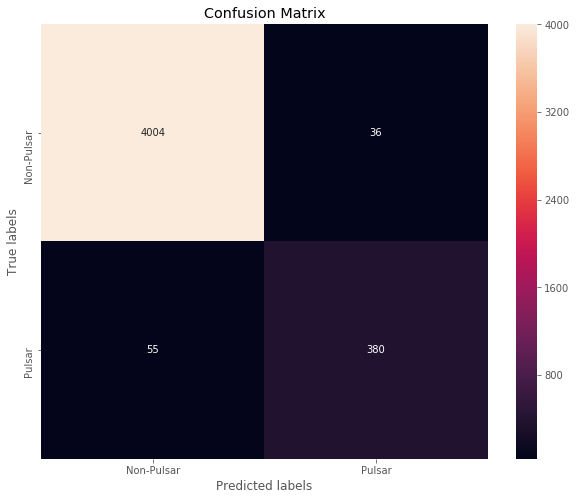

In [151]:
conf_matrix = confusion_matrix(testY, predictions)

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt     

plt.figure(figsize=(10,8))
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, fmt='d') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Pulsar', 'Pulsar'])
ax.yaxis.set_ticklabels(['Non-Pulsar', 'Pulsar'])
#plt.savefig('confusion_matrix_wcw.png')

Note that the training loss is much higher than the testing loss, why is it?

A Keras model has two modes: training and testing. Regularization mechanisms, such as Dropout and L1/L2 weight regularization, are turned off at testing time.

Besides, the training loss is the average of the losses over each batch of training data. Because your model is changing over time, the loss over the first batches of an epoch is generally higher than over the last batches. On the other hand, the testing loss for an epoch is computed using the model as it is at the end of the epoch, resulting in a lower loss.

For more informations, see:
http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/
https://forums.fast.ai/t/validation-loss-lower-than-training-loss/4581/2

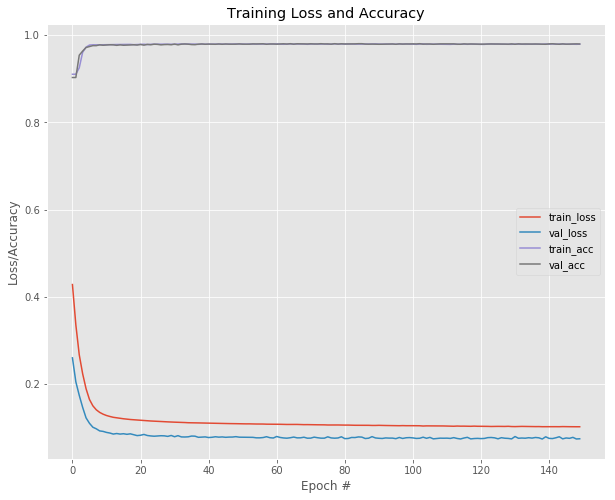

In [152]:
# Plotting the curve Epoch vs. Loss/Accuracy
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(np.arange(0, 150), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 150), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 150), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 150), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#plt.savefig('plot_wcw.png')

In [153]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testY, predictions)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

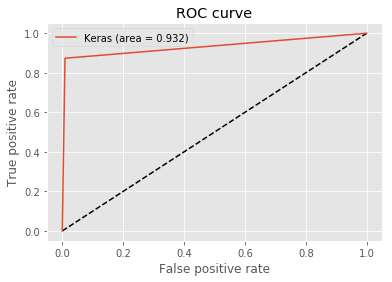

In [154]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()